# All the Linear Algebra You Need for AI

The purpose of this notebook is to serve as an explanation of two crucial linear algebra operations used when coding neural networks: matrix multiplication and broadcasting.

## Introduction

**Matrix multiplication** is a way of combining two matrices (involving multiplying and summing their entries in a particular way).  **Broadcasting** refers to how libraries such as Numpy and PyTorch can perform operations on matrices/vectors with mismatched dimensions (in particular cases, with set rules).  We will use broadcasting to show an alternative way of thinking about matrix multiplication from, different from the way it is standardly taught.

In keeping with the [fast.ai teaching philosophy](http://www.fast.ai/2016/10/08/teaching-philosophy/) of ["the whole game"](https://www.amazon.com/Making-Learning-Whole-Principles-Transform/dp/0470633719/ref=sr_1_1?ie=UTF8&qid=1505094653), we will:

- first use a pre-defined class for our neural network
- then define the net ourselves to see where it uses matrix multiplication & broadcasting
- and finally dig into the details of how those operations work

This is different from how most math courses are taught, where you have to learn all the individual elements before you can combine them (Harvard professor David Perkins call this *elementitis*), but it is similar to how topics like *driving* and *baseball* are taught.  That is, you can start driving without [knowing how an internal combustion engine works](https://medium.com/towards-data-science/thoughts-after-taking-the-deeplearning-ai-courses-8568f132153), and children begin playing baseball before they learn all the formal rules.

<img src="images/demba_combustion_engine.png" alt="" style="width: 50%"/>
<center>
(source: [Demba Ba](https://github.com/zalandoresearch/fashion-mnist) and [Arvind Nagaraj](https://medium.com/towards-data-science/thoughts-after-taking-the-deeplearning-ai-courses-8568f132153))
</center>

### More linear algebra resources

This notebook was originally created for a 40 minute talk I gave at the [O'Reilly AI conference in San Francisco](https://conferences.oreilly.com/artificial-intelligence/ai-ca).  If you want further resources for linear algebra, here are a few recommendations:

- [3Blue1Brown Essence of Linear Algebra](https://www.youtube.com/playlist?list=PLZHQObOWTQDPD3MizzM2xVFitgF8hE_ab) videos about *geometric intuition* (fantastic! gorgeous!)
- [Khan Academy Linear Algebra](https://www.khanacademy.org/math/linear-algebra)
- [Immersive linear algebra](http://immersivemath.com/ila/) free online textbook with interactive graphics
- [Chapter 2](http://www.deeplearningbook.org/contents/linear_algebra.html) of Ian Goodfellow's Deep Learning Book
- [Computational Linear Algebra](http://www.fast.ai/2017/07/17/num-lin-alg/): a free, online fast.ai course, originally taught in the University of San Francisco's Masters in Analytics program. It includes a free [online textbook](https://github.com/fastai/numerical-linear-algebra/blob/master/README.md) and [series of videos](https://www.youtube.com/playlist?list=PLtmWHNX-gukIc92m1K0P6bIOnZb-mg0hY). This course is very different from standard linear algebra (which often focuses on how **humans** do matrix calculations), because it is about how to get **computers** to do matrix computations with speed and accuracy, and incorporates modern tools and algorithms.  All the material is taught in Python and centered around solving practical problems such as removing the background from a surveillance video or implementing Google's PageRank search algorithm on Wikipedia pages.

## Our Tools

We will be using the open source fast.ai [deep learning library, fastai](https://github.com/fastai/fastai), which provides high level abstractions and best practices on top of PyTorch.

In [1]:
import sys
sys.path.insert(0, '../')

In [2]:
%load_ext autoreload
%autoreload 2

In [8]:
from fastai.imports import *
from fastai.torch_imports import *
from fastai.io import *

### PyTorch

The fastai deep learning library uses [PyTorch](http://pytorch.org/), a Python framework for tensors and dynamic neural networks with GPU acceleration, which was released by Facebook's AI team.  

From the [PyTorch documentation](http://pytorch.org/tutorials/beginner/blitz/tensor_tutorial.html):

<img src="images/what_is_pytorch.png" alt="pytorch" style="width: 80%"/>

**Further learning**: If you are curious to learn what *dynamic* neural networks are, you may want to watch [this talk](https://www.youtube.com/watch?v=Z15cBAuY7Sc) by Soumith Chintala, Facebook AI researcher and core PyTorch contributor.

If you want to learn more PyTorch, you can try this [tutorial](http://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) or this [learning by examples](http://pytorch.org/tutorials/beginner/pytorch_with_examples.html).

**Note about GPUs**: If you are not using a GPU, you will need to remove the `.cuda()` from the methods below. GPU usage is not required for this tutorial, but I thought it would be of interest to some of you.  To learn how to create an AWS instance with a GPU, you can watch the [fast.ai setup lesson](http://course.fast.ai/lessons/aws.html).]

## Data

A matrix can represent an image, by creating a grid where each entry corresponds to a different pixel.

<img src="images/digit.gif" alt="digit" style="width: 55%"/>
  (Source: [Adam Geitgey
](https://medium.com/@ageitgey/machine-learning-is-fun-part-3-deep-learning-and-convolutional-neural-networks-f40359318721))


Today we will be working with MNIST, a classic data set of hand-written digits.  Solutions to this problem are used by banks to automatically recognize the amounts on checks, and by the postal service to automatically recognize zip codes on mail.

<img src="images/mnist.png" alt="" style="width: 60%"/>

Next, we will look at **CIFAR 10**, a dataset that consists of 32x32 *color* images in 10 different categories.  Color images have an extra dimension, containing RGB values, compared to black & white images.

<img src="images/cifar10.png" alt="" style="width: 70%"/>
<center>
(source: [Cifar 10](https://www.cs.toronto.edu/~kriz/cifar.html))
</center>

### Download

Let's download, unzip, and format the data.

In [14]:
path = '../data/'

In [15]:
import os
os.makedirs(path, exist_ok=True)

In [16]:
URL='http://deeplearning.net/data/mnist/'
FILENAME='mnist.pkl.gz'

def load_mnist(filename):
    return pickle.load(gzip.open(filename, 'rb'), encoding='latin-1')

In [17]:
get_data(URL+FILENAME, path+FILENAME)
((x, y), (x_valid, y_valid), (x_test, y_test)) = load_mnist(path+FILENAME)

### Normalize

One of the challenges in training neural networks is keeping your numbers from exploding (going to infinity) or vanishing (going to zero).  There are several different ways to add normalization to address this.  We will subtract off the mean and standard deviation from our training set:

In [18]:
mean = x.mean()
std = x.std()

In [19]:
x=(x-mean)/std
x.mean(), x.std()

(-3.1638146e-07, 0.99999934)

Note that for consistency (with the parameters we learn when training), we subtract the mean and standard deviation of our training set from our validation set. 

In [20]:
x_valid = (x_valid-mean)/std
x_valid.mean(), x_valid.std()

(-0.0058509219, 0.99243325)

### Look at the data

#### Helper methods

In [21]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [22]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation='none', cmap='gray')

In any sort of data science work, it's important to look at your data, to make sure you understand the format, how it's stored, what type of values it holds, etc. To make it easier to work with, let's reshape it into 2d images from the flattened 1d format.

#### Helper methods

In [23]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

def show(img, title=None):
    plt.imshow(img, interpolation='none', cmap="gray")
    if title is not None: plt.title(title)

In [24]:
def plots(ims, figsize=(12,6), rows=2, titles=None):
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation='none', cmap='gray')

#### Plots 

In [25]:
x_imgs = np.reshape(x_valid, (-1,28,28)); x_imgs.shape

(10000, 28, 28)

We can look at part of an image:

In [26]:
x_imgs[0,10:15,10:15]

array([[-0.4245, -0.4245, -0.4245, -0.4245,  0.1729],
       [-0.4245, -0.4245, -0.4245,  0.7831,  2.4357],
       [-0.4245, -0.272 ,  1.2026,  2.7789,  2.8043],
       [-0.4245,  1.7619,  2.8043,  2.8043,  1.7365],
       [-0.4245,  2.2069,  2.8043,  2.8043,  0.4018]], dtype=float32)

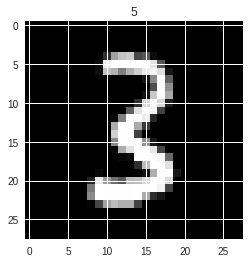

In [27]:
show(x_imgs[0], y[0])

It's the digit 5!  And that's stored in the y value:

In [28]:
y[0]

5

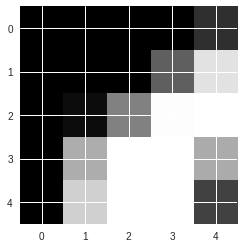

In [29]:
show(x_imgs[0,10:15,10:15])

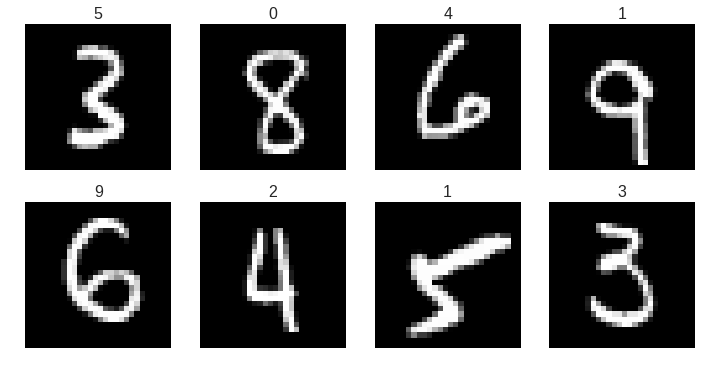

In [30]:
plots(x_imgs[:8], titles=y[:8])

## Neural Net (with nn.torch)

We will begin with the highest level abstraction: using a neural net defined by PyTorch's Sequential class (Keras has a similar Sequential class).  

We will use fastai's ImageClassifierData, which holds our training and validation sets and will provide batches of that data in a form ready for use by a PyTorch model.

In [31]:
from fastai.metrics import *
from fastai.model import *
from fastai.dataset import *
from fastai.core import *

import torch.nn as nn

In [32]:
md = ImageClassifierData.from_arrays(path, (x,y), (x_valid, y_valid))

Neural networks consist of **linear layers alternating with non-linear layers**.  This creates functions which are incredibly flexible.

In [33]:
net = nn.Sequential(
    nn.Linear(28*28, 256),
    nn.ReLU(),
    nn.Linear(256, 10)
).cuda()

Each input is a vector of size $28\times 28$ pixels and our output is of size $10$ (since there are 10 digits: 0, 1, ..., 9).

I just chose $256$ as the number of hidden states, you could change this to something else.

Next we will set a few inputs for our *fit* method:
- **Loss**: what function is the optimizer trying to minimize?  We need to say how we're defining the error.
- **Optimizer**: algorithm for finding the minimum. typically these are variations on *stochastic gradient descent*, involve taking a step that appears to be the right direction based on the gradient
- **Metrics**: other calculations you want printed out as you train

In [34]:
loss=F.cross_entropy
metrics=[accuracy]
opt=optim.Adam(net.parameters())

*Fitting* is the process by which the neural net learns the best parameters for the dataset.

In [35]:
fit(net, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

[ 0.1397  0.1193  0.9668]



Now that we have the parameters for our model, we can make predictions on our validation set.

In [36]:
preds = predict(net, md.val_dl)

In [37]:
preds = preds.max(1)[1]

Let's see how some of our preditions look!

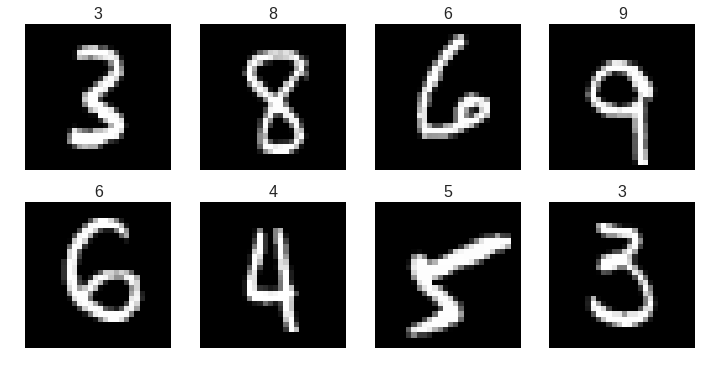

In [38]:
plots(x_imgs[:8], titles=preds[:8])

These predictions are pretty good! Note that the image in the 2nd column of the 2nd row appears to be a 4, yet is labeled 9.  Although incorrect, the way the 4 is drawn does look quite similar to a 9.

## Coding the Neural Net ourselves

Now, instead of using PyTorch's `Sequential`, we will define the neural network ourselves.  This will allow us to see exactly where matrix multiplication is used.  Just as Numpy has `np.matmul` for matrix multiplication (in Python 3, this is equivalent to the `@` operator), PyTorch has `torch.matmul`.  The method `forward` describes how the neural net converts inputs to outputs.

In [86]:
class SimpleMnist(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_w = get_weights(28*28, 256)  # Layer 1 weights
        self.l1_b = get_weights(256)         # Layer 1 bias
        self.l2_w = get_weights(256, 10)     # Layer 2 weights
        self.l2_b = get_weights(10)          # Layer 2 bias

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.matmul(x, self.l1_w) + self.l1_b
        x = x * (x > 0).float()
        x = torch.matmul(x, self.l2_w) + self.l2_b
        return x

In [87]:
from torch.autograd import Variable
def get_weights(*dims): return nn.Parameter(torch.randn(*dims)/dims[0])

We create our neural net and the optimizer.  (We will use the same loss and metrics from above).

In [88]:
net2 = SimpleMnist().cuda()
opt=optim.Adam(net2.parameters())

In [89]:
fit(net2, md, epochs=1, crit=loss, opt=opt, metrics=metrics)

[ 0.1599  0.1465  0.9578]



Now we can check our predictions:

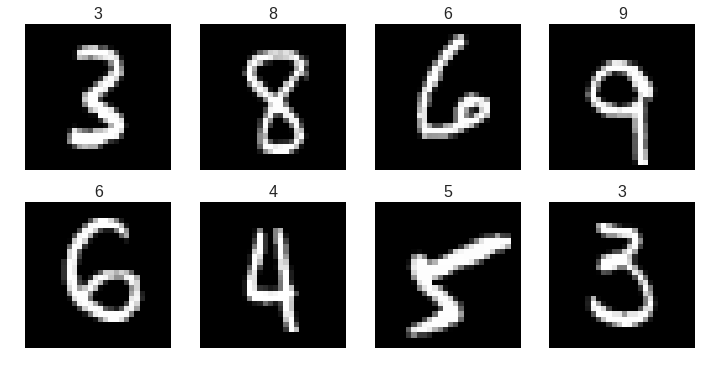

In [90]:
preds = predict(net2, md.val_dl).max(1)[1]
plots(x_imgs[:8], titles=preds[:8])

## what torch.matmul (matrix multiplication) is doing

Now let's dig in to what we were doing with `torch.matmul`: matrix multiplication.  First, let's start with a simpler building block: **broadcasting**.

### Element-wise operations 

Broadcasting and element-wise operations are supported in the same way by both numpy and pytorch.

Operators (+,-,\*,/,>,<,==) are usually element-wise.

Examples of element-wise operations:

In [44]:
a = np.array([10, 6, -4])
b = np.array([2, 8, 7])

In [45]:
a + b

array([12, 14,  3])

In [46]:
a < b

array([False,  True,  True], dtype=bool)

### Broadcasting

The term **broadcasting** describes how arrays with different shapes are treated during arithmetic operations.  The term broadcasting was first used by Numpy, although is now used in other libraries such as [Tensorflow](https://www.tensorflow.org/performance/xla/broadcasting) and Matlab; the rules can vary by library.

From the [Numpy Documentation](https://docs.scipy.org/doc/numpy-1.10.0/user/basics.broadcasting.html):

    Broadcasting provides a means of vectorizing array operations so 
    that looping occurs in C instead of Python. It does this without 
    making needless copies of data and usually leads to efficient 
    algorithm implementations.

This section was adapted from [Chapter 4](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/4.%20Compressed%20Sensing%20of%20CT%20Scans%20with%20Robust%20Regression.ipynb#4.-Compressed-Sensing-of-CT-Scans-with-Robust-Regression) of my [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course.

#### Broadcasting with a scalar

In [66]:
a > 0

array([ True,  True, False], dtype=bool)

How are we able to do a > 0?  0 is being **broadcast** to have the same dimensions as a.

Other examples of broadcasting with a scalar (as we did when we normalized our data):

In [67]:
a + 1

array([11,  7, -3])

In [68]:
m = np.array([[1, 2, 3], [4,5,6], [7,8,9]]); m

array([[1, 2, 3],
       [4, 5, 6],
       [7, 8, 9]])

In [69]:
m * 2

array([[ 2,  4,  6],
       [ 8, 10, 12],
       [14, 16, 18]])

#### Broadcasting a vector to a matrix

We can also broadcast a vector to a matrix:

In [70]:
c = np.array([10,20,30]); c

array([10, 20, 30])

In [71]:
m + c

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

Although numpy does this automatically, you can also use the `broadcast_to` method:

In [72]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

In [91]:
c.shape

(3,)

The numpy `expand_dims` method lets us convert the 1-dimensional array `c` into a 2-dimensional array (although one of those dimensions has value 1).

In [74]:
np.expand_dims(c,0).shape

(1, 3)

In [75]:
m + np.expand_dims(c,0)

array([[11, 22, 33],
       [14, 25, 36],
       [17, 28, 39]])

In [76]:
np.expand_dims(c,1).shape

(3, 1)

In [77]:
m + np.expand_dims(c,1)

array([[11, 12, 13],
       [24, 25, 26],
       [37, 38, 39]])

In [78]:
np.broadcast_to(np.expand_dims(c,1), (3,3))

array([[10, 10, 10],
       [20, 20, 20],
       [30, 30, 30]])

#### Broadcasting Rules

When operating on two arrays, Numpy/PyTorch compares their shapes element-wise. It starts with the **trailing dimensions**, and works its way forward. Two dimensions are **compatible** when

- they are equal, or
- one of them is 1

Arrays do not need to have the same number of dimensions. For example, if you have a $256 \times 256 \times 3$ array of RGB values, and you want to scale each color in the image by a different value, you can multiply the image by a one-dimensional array with 3 values. Lining up the sizes of the trailing axes of these arrays according to the broadcast rules, shows that they are compatible:

    Image  (3d array): 256 x 256 x 3
    Scale  (1d array):             3
    Result (3d array): 256 x 256 x 3

### Matrix Multiplication

We are going to use broadcasting to define matrix multiplication.

#### Matrix-Vector Multiplication

In [79]:
m, c

(array([[1, 2, 3],
        [4, 5, 6],
        [7, 8, 9]]), array([10, 20, 30]))

In [93]:
m @ c  # np.matmul(m, c)

array([140, 320, 500])

We get the same answer using `torch.matmul`:

In [92]:
torch.matmul(torch.from_numpy(m), torch.from_numpy(c))


 140
 320
 500
[torch.LongTensor of size 3]

The following is **NOT** matrix multiplication.  What is it?

In [67]:
m * c

array([[ 10,  40,  90],
       [ 40, 100, 180],
       [ 70, 160, 270]])

In [70]:
(m * c).sum(axis=1)

array([140, 320, 500])

In [115]:
c

array([10, 20, 30])

In [114]:
np.broadcast_to(c, (3,3))

array([[10, 20, 30],
       [10, 20, 30],
       [10, 20, 30]])

From a machine learning perspective, matrix multiplication is a way of creating features by saying how much we want to weight each input column.  **Different features are different weighted averages of the input columns**. 

The website [matrixmultiplication.xyz](http://matrixmultiplication.xyz/) provides a nice visualization of matrix multiplcation

Draw a picture

In [118]:
d = np.array([30,20,10])

In [127]:
nn = np.stack([c, d], axis=1); nn

array([[10, 30],
       [20, 20],
       [30, 10]])

In [116]:
n = np.array([[10,30],[20,20],[30,10]])

In [117]:
m @ n

array([[140, 100],
       [320, 280],
       [500, 460]])

In [107]:
(m * c).sum(axis=1)

array([140, 320, 500])

In [129]:
(m * d).sum(axis=1)

array([100, 280, 460])

## Other applications of Matrix and Tensor Products

Here are some other examples of where matrix multiplication arises.  This material is taken from [Chapter 1](http://nbviewer.jupyter.org/github/fastai/numerical-linear-algebra/blob/master/nbs/1.%20Why%20are%20we%20here.ipynb) of my [Computational Linear Algebra](https://github.com/fastai/numerical-linear-algebra) course. 

#### Matrix-Vector Products:

The matrix below gives the probabilities of moving from 1 health state to another in 1 year.  If the current health states for a group are:
- 85% asymptomatic
- 10% symptomatic
- 5% AIDS
- 0% death

what will be the % in each health state in 1 year?

<img src="images/markov_health.jpg" alt="floating point" style="width: 80%"/>(Source: [Concepts of Markov Chains](https://www.youtube.com/watch?v=0Il-y_WLTo4))

#### Answer

In [6]:
import numpy as np

In [19]:
#Exercise: Use Numpy to compute the answer to the above


array([[ 0.765 ],
       [ 0.1525],
       [ 0.0645],
       [ 0.018 ]])

#### Matrix-Matrix Products

<img src="images/shop.png" alt="floating point" style="width: 100%"/>(Source: [Several Simple Real-world Applications of Linear Algebra Tools](https://www.mff.cuni.cz/veda/konference/wds/proc/pdf06/WDS06_106_m8_Ulrychova.pdf))

#### Answer

In [23]:
#Exercise: Use Numpy to compute the answer to the above


array([[ 50. ,  49. ],
       [ 58.5,  61. ],
       [ 43.5,  43.5]])

## End

A Tensor is a *multi-dimensional matrix containing elements of a single data type*: a group of data, all with the same type (e.g. A Tensor could store a 4 x 4 x 6 matrix of 32-bit signed integers).